In [2]:
!pip install torch torchvision transformers
!apt-get install -y libsndfile1


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
import cv2
from shutil import copyfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

vit_dataset_path = "/content/drive/MyDrive/VITformat"
train_images_path = os.path.join(vit_dataset_path, "train")

class_names = ["with_mask", "without_mask", "mask_weared_incorrect"]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=train_images_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(class_names))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

for epoch in range(80):
    model.train()
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}")

torch.save(model.state_dict(), "/content/drive/MyDrive/vit_model.pth")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        predictions = torch.argmax(outputs, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy: {correct / total * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.21151710483126152
Epoch 2, Loss: 0.035634478410849206
Epoch 3, Loss: 0.01867697688822563
Epoch 4, Loss: 0.013823262630746914
Epoch 5, Loss: 0.01073739460359017
Epoch 6, Loss: 0.008571861037172569
Epoch 7, Loss: 0.007003880583514006
Epoch 8, Loss: 0.0058260998951318935
Epoch 9, Loss: 0.004913399234796181
Epoch 10, Loss: 0.004205187066243245
Epoch 11, Loss: 0.003632854228504957
Epoch 12, Loss: 0.0031691563244049367
Epoch 13, Loss: 0.002789360315849384
Epoch 14, Loss: 0.002470732230740862
Epoch 15, Loss: 0.0022071928311234866
Epoch 16, Loss: 0.001975609100041672
Epoch 17, Loss: 0.0017831688776660042
Epoch 18, Loss: 0.0016184671728227001
Epoch 19, Loss: 0.001470723869995429
Epoch 20, Loss: 0.0013452968619859372
Epoch 21, Loss: 0.0012349721360712862
Epoch 22, Loss: 0.0011336141570399587
Epoch 23, Loss: 0.0010481413829928408
Epoch 24, Loss: 0.000967902229883923
Epoch 25, Loss: 0.0008988704917450937
Epoch 26, Loss: 0.0008352128102276952
Epoch 27, Loss: 0.0007786707630237708
E

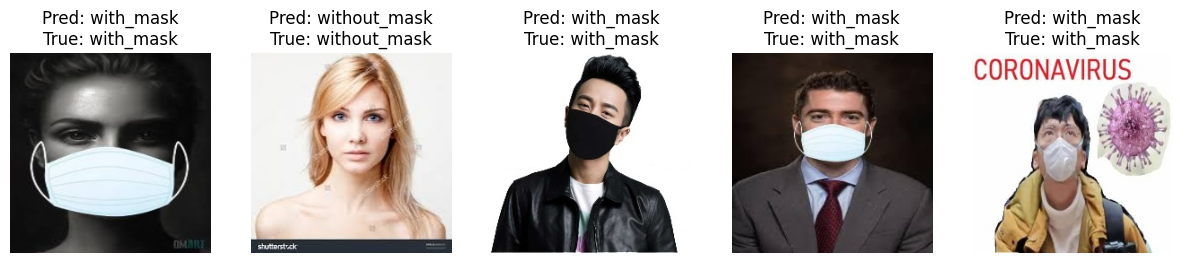

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

def show_image_predictions(model, data_loader, class_names, num_images=5):
    model.eval()

    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images).logits
    predictions = torch.argmax(outputs, dim=-1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].cpu().numpy().transpose((1, 2, 0))  r
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}")

    plt.show()

show_image_predictions(model, data_loader, class_names)


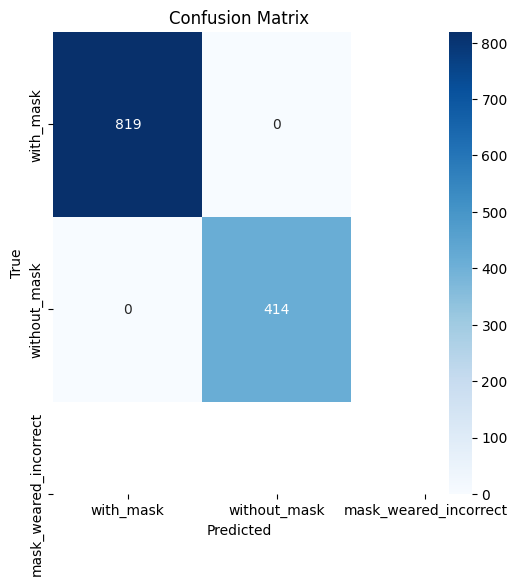

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        predictions = torch.argmax(outputs, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [7]:
torch.save(model.state_dict(), "/content/drive/MyDrive/vit_model.pth")
